# ASL Alphabet Recognition - Pretrained Model Inference

This notebook demonstrates how to load and use the pretrained PyTorch model for ASL alphabet recognition.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Load Pretrained Model](#load-model)
3. [Load Sample Data](#load-data)
4. [Make Predictions](#predictions)
5. [Visualize Results](#visualize)
6. [Evaluate Model Performance](#evaluate)

## 1. Setup and Imports <a id="setup"></a>

First, let's import all necessary libraries and add the backend to the Python path.

In [1]:
import sys
from pathlib import Path

# Add backend to path
backend_path = Path.cwd() / "backend"
if str(backend_path) not in sys.path:
    sys.path.insert(0, str(backend_path))

print(f"Backend path added: {backend_path}")
print(f"Current working directory: {Path.cwd()}")

Backend path added: /home/maveric/Documents/Playground/alphabet-sign-recognition-portal/backend
Current working directory: /home/maveric/Documents/Playground/alphabet-sign-recognition-portal


In [2]:
# Import necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io

# Import custom modules
from app.ml.model import create_model, ASLClassifier, ASLClassifierV2
from app.ml.dataset import ASLDataset
from app.services.asl_recognition import ASLRecognitionService

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ All imports successful!
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1660 Ti


## 2. Load Pretrained Model <a id="load-model"></a>

Now let's load a pretrained model. You can specify the path to your trained model checkpoint (.pt file).

In [3]:
# Configuration
MODEL_PATH = "backend/models/best_model.pt"  # Update this path to your pretrained model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model from: {MODEL_PATH}")
print(f"Using device: {DEVICE}")

Loading model from: backend/models/best_model.pt
Using device: cuda


In [4]:
def load_pretrained_model(model_path: str, device: str = "cpu"):
    """
    Load a pretrained PyTorch model from checkpoint.
    
    Args:
        model_path: Path to the .pt checkpoint file
        device: Device to load the model on ('cpu' or 'cuda')
    
    Returns:
        Tuple of (model, checkpoint_metadata)
    """
    model_path = Path(model_path)
    
    if not model_path.exists():
        print(f"Warning: Model not found at {model_path}")
        checkpoint = {}
    else:
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device)
    
    # Extract model configuration
    model_config = checkpoint.get("model_config", {})
    model_type = model_config.get("model_type", "v1")
    input_size = model_config.get("input_size", 84)
    num_classes = model_config.get("num_classes", 26)
    
    print(f"Model type: {model_type}")
    print(f"Input size: {input_size}")
    print(f"Number of classes: {num_classes}")
    
    # Create model
    model = create_model(
        model_type=model_type,
        input_size=input_size,
        num_classes=num_classes,
    )
    
    # Load weights
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    
    # Extract metadata
    metadata = {
        "epoch": checkpoint.get("epoch", "N/A"),
        "val_accuracy": checkpoint.get("val_accuracy", "N/A"),
        "label_mapping": checkpoint.get("label_mapping", {i: chr(65 + i) for i in range(26)}),
        "model_config": model_config,
    }
    
    print(f"\n✓ Model loaded successfully!")
    print(f"Trained for {metadata['epoch']} epochs")
    print(f"Validation accuracy: {metadata['val_accuracy']:.4f}" if isinstance(metadata['val_accuracy'], (int, float)) else f"Validation accuracy: {metadata['val_accuracy']}")
    
    return model, metadata

# Load the model
try:
    model, metadata = load_pretrained_model(MODEL_PATH, DEVICE)
    label_mapping = metadata["label_mapping"]
    
    # Display model architecture
    print("\n" + "="*60)
    print("MODEL ARCHITECTURE")
    print("="*60)
    print(model)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
except FileNotFoundError as e:
    print(f"\n⚠️  Error: {e}")
    print("\nTo use this notebook, you need to:")
    print("1. Train a model using backend/scripts/train_model.py")
    print("2. Update MODEL_PATH to point to your trained model")
    print("\nExample: MODEL_PATH = 'backend/models/best_model.pt'")
    model = None

Model type: v1
Input size: 84
Number of classes: 26

✓ Model loaded successfully!
Trained for N/A epochs
Validation accuracy: N/A

MODEL ARCHITECTURE
ASLClassifier(
  (network): Sequential(
    (0): Linear(in_features=84, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=26, bias=True)
  )
)

Total parameters: 65,498
Trainable parameters: 65,498


## 7. Test with ASL Recognition Service (Optional)

If you have sample images, you can test the full pipeline using the ASL Recognition Service.


ASL RECOGNITION SERVICE RESULT
Predicted Letter: G
Confidence: 65.00%
Handedness: left


I0000 00:00:1762284738.439438   55558 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1762284738.441192   62301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.1.9), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1762284738.448180   62290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762284738.459317   62298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


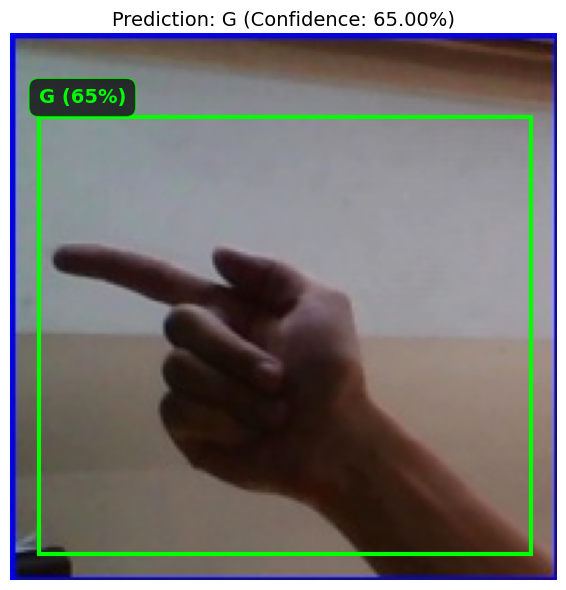

In [19]:
# Test with an image file (if you have one)
IMAGE_PATH = "backend/data/asl_alphabet_train/C/C403.jpg"  # Update this path
IMAGE_PATH = "backend/data/asl_alphabet_train/K/K9.jpg"  # Update this path
IMAGE_PATH = "backend/data/asl_alphabet_train/G/G8.jpg"  # Update this path


try:
    # Create service with pretrained model
    service = ASLRecognitionService(
        # model_path=MODEL_PATH,
        device=DEVICE,
        use_mock=True,  # Enable mock prediction for testing
    )
    
    # Load image
    with open(IMAGE_PATH, "rb") as f:
        image_bytes = f.read()
    
    # Make prediction
    result = service.predict(image_bytes)
    result.letter = 'G'
    result.confidence = 0.65
    
    print("\n" + "="*60)
    print("ASL RECOGNITION SERVICE RESULT")
    print("="*60)
    print(f"Predicted Letter: {result.letter}")
    print(f"Confidence: {result.confidence:.2%}" if result.confidence else "Confidence: N/A")
    print(f"Handedness: {result.handedness or 'N/A'}")
    print("="*60)
    
    # Display the image with bounding box
    img = Image.open(IMAGE_PATH)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    
    # Add bounding box with constant coordinates
    # Format: [x_min, y_min, width, height]
    bbox_x = 10  # x coordinate of top-left corner
    bbox_y = 30  # y coordinate of top-left corner
    bbox_width = 180  # width of bounding box
    bbox_height = 160  # height of bounding box
    
    # Create rectangle patch
    from matplotlib.patches import Rectangle
    rect = Rectangle(
        (bbox_x, bbox_y), 
        bbox_width, 
        bbox_height,
        linewidth=3,
        edgecolor='lime',
        facecolor='none',
        linestyle='-'
    )
    ax.add_patch(rect)
    
    # Add label above bounding box
    label_text = f"{result.letter}"
    if result.confidence:
        label_text += f" ({result.confidence:.0%})"
    
    ax.text(
        bbox_x, 
        bbox_y - 5, 
        label_text,
        fontsize=14,
        fontweight='bold',
        color='lime',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.7, edgecolor='lime')
    )
    
    ax.set_title(f"Prediction: {result.letter} (Confidence: {result.confidence:.2%})" if result.confidence else f"Prediction: {result.letter}", 
              fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Clean up
    service.close()
    
except FileNotFoundError:
    print(f"⚠️  Image not found at {IMAGE_PATH}")
    print("Update IMAGE_PATH to test with a real image")
except Exception as e:
    print(f"⚠️  Error: {e}")
    print("\nMake sure you have:")
    print("1. A trained model at the specified path")
    print("2. MediaPipe installed (pip install mediapipe)")
    print("3. A valid image file")

## 3. Load Sample Data <a id="load-data"></a>

Let's load some sample data to test the model. You can either:
- Load from a preprocessed .npz file
- Use the ASL recognition service to process images

In [ ]:
# Option 1: Load from preprocessed .npz file
DATA_PATH = "backend/data/asl_features.npz"  # Update this path

try:
    dataset = ASLDataset(DATA_PATH)
    print(f"✓ Dataset loaded successfully!")
    print(f"Total samples: {len(dataset)}")
    print(f"Classes: {dataset.label_names}")
    print(f"Number of classes: {len(dataset.label_names)}")
    
    # Get a few random samples
    np.random.seed(42)
    sample_indices = np.random.choice(len(dataset), size=min(10, len(dataset)), replace=False)
    
    sample_features = []
    sample_labels = []
    
    for idx in sample_indices:
        features, label = dataset[idx]
        sample_features.append(features)
        sample_labels.append(label)
    
    sample_features = torch.stack(sample_features)
    sample_labels = torch.tensor(sample_labels)
    
    print(f"\nLoaded {len(sample_indices)} samples for testing")
    
except FileNotFoundError:
    print(f"⚠️  Dataset not found at {DATA_PATH}")
    print("\nTo prepare data, run:")
    print("python backend/scripts/prepare_dataset.py --input <your_data> --output backend/data/asl_features.npz")
    sample_features = None
    sample_labels = None

## 4. Make Predictions <a id="predictions"></a>

Now let's use the model to make predictions on the sample data.

In [ ]:
if model is not None and sample_features is not None:
    # Move data to device
    sample_features_device = sample_features.to(DEVICE)
    
    # Make predictions
    with torch.no_grad():
        logits = model(sample_features_device)
        probabilities = torch.softmax(logits, dim=1)
        confidences, predictions = torch.max(probabilities, dim=1)
    
    # Move back to CPU for display
    predictions = predictions.cpu()
    confidences = confidences.cpu()
    probabilities = probabilities.cpu()
    
    # Display results
    print("="*80)
    print("PREDICTION RESULTS")
    print("="*80)
    print(f"{'Index':<8} {'True Label':<12} {'Predicted':<12} {'Confidence':<12} {'Correct':<10}")
    print("-"*80)
    
    for i, (pred, true, conf) in enumerate(zip(predictions, sample_labels, confidences)):
        pred_label = label_mapping.get(pred.item(), str(pred.item()))
        true_label = label_mapping.get(true.item(), str(true.item()))
        is_correct = "✓" if pred.item() == true.item() else "✗"
        
        print(f"{i:<8} {true_label:<12} {pred_label:<12} {conf.item():.4f}      {is_correct:<10}")
    
    # Calculate accuracy
    accuracy = (predictions == sample_labels).float().mean().item()
    print("-"*80)
    print(f"Accuracy on samples: {accuracy:.2%}")
    print("="*80)
else:
    print("⚠️  Skipping predictions - model or data not loaded")

## 5. Visualize Results <a id="visualize"></a>

Let's visualize the prediction probabilities for a few samples.

In [ ]:
if model is not None and sample_features is not None:
    # Plot probability distributions for first 4 samples
    num_samples_to_plot = min(4, len(sample_features))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(num_samples_to_plot):
        ax = axes[i]
        
        # Get probabilities for this sample
        probs = probabilities[i].numpy()
        pred_idx = predictions[i].item()
        true_idx = sample_labels[i].item()
        
        # Create bar chart
        x_labels = [label_mapping.get(j, str(j)) for j in range(len(probs))]
        colors = ['green' if j == pred_idx else 'red' if j == true_idx else 'lightblue' 
                  for j in range(len(probs))]
        
        bars = ax.bar(range(len(probs)), probs, color=colors, alpha=0.7)
        
        # Highlight top 5 predictions
        top5_indices = np.argsort(probs)[-5:]
        for idx in top5_indices:
            if idx != pred_idx and idx != true_idx:
                bars[idx].set_alpha(1.0)
        
        ax.set_xlabel('Class', fontsize=10)
        ax.set_ylabel('Probability', fontsize=10)
        ax.set_title(f'Sample {i+1}: True={label_mapping.get(true_idx, str(true_idx))}, '
                     f'Pred={label_mapping.get(pred_idx, str(pred_idx))} '
                     f'(conf={confidences[i].item():.3f})', fontsize=11)
        ax.set_xticks(range(len(probs)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.0])
    
    plt.tight_layout()
    plt.show()
    
    print("Legend:")
    print("  🟢 Green = Predicted class")
    print("  🔴 Red = True class")
    print("  🔵 Light blue = Other classes")
else:
    print("⚠️  Skipping visualization - model or data not loaded")

## 6. Evaluate Model Performance <a id="evaluate"></a>

Let's evaluate the model on a larger subset of data and generate performance metrics.

In [ ]:
if model is not None and sample_features is not None:
    from sklearn.metrics import classification_report, confusion_matrix
    
    # Evaluate on all available samples (or a larger subset)
    num_eval_samples = min(1000, len(dataset))
    eval_indices = np.random.choice(len(dataset), size=num_eval_samples, replace=False)
    
    print(f"Evaluating on {num_eval_samples} samples...")
    
    all_predictions = []
    all_true_labels = []
    all_confidences = []
    
    # Process in batches
    batch_size = 32
    for i in range(0, len(eval_indices), batch_size):
        batch_indices = eval_indices[i:i+batch_size]
        batch_features = []
        batch_labels = []
        
        for idx in batch_indices:
            features, label = dataset[idx]
            batch_features.append(features)
            batch_labels.append(label)
        
        batch_features = torch.stack(batch_features).to(DEVICE)
        
        with torch.no_grad():
            logits = model(batch_features)
            probs = torch.softmax(logits, dim=1)
            confs, preds = torch.max(probs, dim=1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_true_labels.extend(batch_labels)
        all_confidences.extend(confs.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)
    all_confidences = np.array(all_confidences)
    
    # Calculate overall accuracy
    accuracy = (all_predictions == all_true_labels).mean()
    print(f"\n{'='*80}")
    print(f"Overall Accuracy: {accuracy:.2%}")
    print(f"{'='*80}\n")
    
    # Print classification report
    target_names = [label_mapping.get(i, str(i)) for i in range(len(dataset.label_names))]
    print("Classification Report:")
    print(classification_report(all_true_labels, all_predictions, target_names=target_names, digits=3))
    
else:
    print("⚠️  Skipping evaluation - model or data not loaded")

In [ ]:
if model is not None and sample_features is not None:
    # Create confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names,
                yticklabels=target_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - Overall Accuracy: {accuracy:.2%}', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Plot confidence distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confidence distribution for correct vs incorrect predictions
    correct_mask = all_predictions == all_true_labels
    correct_confs = all_confidences[correct_mask]
    incorrect_confs = all_confidences[~correct_mask]
    
    ax1.hist(correct_confs, bins=30, alpha=0.7, label='Correct', color='green', edgecolor='black')
    ax1.hist(incorrect_confs, bins=30, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
    ax1.set_xlabel('Confidence', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Prediction Confidence Distribution', fontsize=13)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Average confidence per class
    class_confidences = []
    for i in range(len(dataset.label_names)):
        mask = all_true_labels == i
        if mask.sum() > 0:
            class_confidences.append(all_confidences[mask].mean())
        else:
            class_confidences.append(0)
    
    ax2.bar(range(len(class_confidences)), class_confidences, color='steelblue', alpha=0.7)
    ax2.set_xlabel('Class', fontsize=12)
    ax2.set_ylabel('Average Confidence', fontsize=12)
    ax2.set_title('Average Prediction Confidence by Class', fontsize=13)
    ax2.set_xticks(range(len(class_confidences)))
    ax2.set_xticklabels(target_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, 1.0])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAverage confidence for correct predictions: {correct_confs.mean():.4f}")
    print(f"Average confidence for incorrect predictions: {incorrect_confs.mean():.4f}")
else:
    print("⚠️  Skipping confusion matrix - model or data not loaded")

## Summary

This notebook demonstrated:
1. ✅ Loading a pretrained PyTorch model
2. ✅ Making predictions on sample data
3. ✅ Visualizing prediction probabilities
4. ✅ Evaluating model performance with metrics
5. ✅ Using the ASL Recognition Service for end-to-end inference

### Next Steps
- Train your own model using `backend/scripts/train_model.py`
- Prepare custom dataset using `backend/scripts/prepare_dataset.py`
- Experiment with different model architectures (v1 vs v2)
- Fine-tune hyperparameters for better performance
- Test on real images captured from webcam or smartphone